In [158]:
# imports
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
from functools import partial
import sys
from pathlib import Path

# imports for continuous DR
import numpy as np
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from statsmodels.nonparametric.kernel_regression import KernelReg
from scipy.optimize import minimize_scalar
import statsmodels.api as sm
from sklearn.model_selection._split import KFold

# imports for discrete DR
import pandas as pd
import doubleml as dml
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

import torch
import os
import time
from functools import partial

# change import path
path = Path.cwd().parents[1]
if str(path) not in sys.path:
    sys.path.append(str(path))

from src.continuous_DR import *
from src.dgps import *

In [47]:
# Getting observational and interventional data
n = 100
n_int = 2
int_samples = 10**4
noise = 1.0
seed = 1
front_door = False
int_scale = 1

if front_door:
    method = "ATT_frontdoor_doB_b"
else:
    method = "CATE_backdoor_doD_bfixed"
    
A,B,C,D,E,Y,vals,EY = Simulation(n,n_int, 
           mc_samples_EYdoX = int_samples, 
           seed = seed, 
           draw_EYdoX = True, 
           noise = noise,
           method = method, 
           int_min=-int_scale*noise, 
           int_max = int_scale*noise,
           discrete_D = True,
           fix_b = False
            )

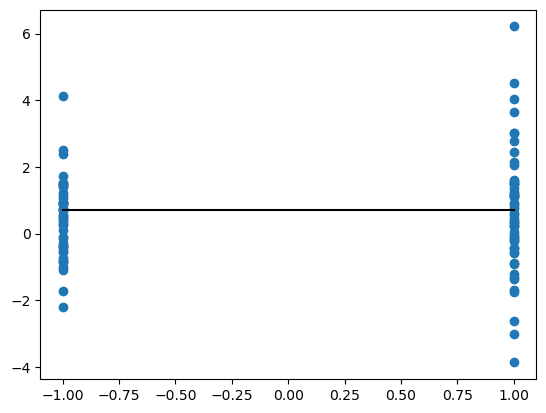

In [49]:
plt.plot(vals,EY, color = "black")
if front_door:
    plt.scatter(B,Y)
else:
    plt.scatter(D,Y)

## Discrete DR

In [149]:
torch.linspace(0,1,101)

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
        0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
        0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
        0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
        0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
        0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
        0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
        0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
        0.9900, 1.0000])

In [144]:
# Set up basic model: Specify variables for data-backend
features_base = ['C']

# Initialize DoubleMLData (data-backend of DoubleML)
Data = pd.DataFrame((D+1)/2, columns=['D'])
Data['B'] = B
Data['C'] = C
Data['Y'] = Y
data_dml_base = dml.DoubleMLData(Data,
                                 y_col='Y',
                                 d_cols='D',
                                 x_cols=features_base)

# Random Forest (IRM)
randomForest = RandomForestRegressor(n_estimators=100,max_features=3, max_depth=3, min_samples_leaf=3)
randomForest_class = RandomForestClassifier(n_estimators=100,max_features=3, max_depth=3, min_samples_leaf=3)

np.random.seed(1)
dml_irm_forest = dml.DoubleMLIRM(data_dml_base,
                                 ml_g = randomForest,
                                 ml_m = randomForest_class,
                                 trimming_threshold = 0.01,
                                 n_folds = 5,
                                 score = "ATE",
                                 n_rep = 1)

dml_irm_forest.fit(store_predictions=True)
forest_summary = dml_irm_forest.summary

print(forest_summary)

      coef  std err         t     P>|t|     2.5 %    97.5 %
D  0.88409  0.61863  1.429111  0.152972 -0.328402  2.096582


## CATE DR

In [156]:
quantiles = torch.linspace(0,1,90)

In [157]:
import patsy
design_matrix = patsy.dmatrix("bs(x, df=5, degree=5)", {"x": Data["B"]})
spline_basis = pd.DataFrame(design_matrix)

cate = dml_irm_forest.cate(spline_basis)
#print(cate)

new_data = {"x": np.linspace(0, 0, 1)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
for i in range(1,100):
    df_cate = cate.confint(spline_grid, level=quantiles[i].item(), joint=False, n_rep_boot=1000)
    print(df_cate)

     49.4 %    effect  50.6 %
0 -0.022142 -0.010021  0.0021
     48.9 %    effect    51.1 %
0 -0.034266 -0.010021  0.014223
     48.3 %    effect    51.7 %
0 -0.046394 -0.010021  0.026352
    47.8 %    effect    52.2 %
0 -0.05853 -0.010021  0.038487
     47.2 %    effect    52.8 %
0 -0.070675 -0.010021  0.050633
     46.6 %    effect   53.4 %
0 -0.082832 -0.010021  0.06279
     46.1 %    effect    53.9 %
0 -0.095004 -0.010021  0.074962
     45.5 %    effect    54.5 %
0 -0.107193 -0.010021  0.087151
     44.9 %    effect    55.1 %
0 -0.119401 -0.010021  0.099359
     44.4 %    effect    55.6 %
0 -0.131632 -0.010021  0.111589
     43.8 %    effect    56.2 %
0 -0.143887 -0.010021  0.123844
     43.3 %    effect    56.7 %
0 -0.156169 -0.010021  0.136127
     42.7 %    effect    57.3 %
0 -0.168481 -0.010021  0.148439
     42.1 %    effect    57.9 %
0 -0.180826 -0.010021  0.160783
     41.6 %    effect    58.4 %
0 -0.193206 -0.010021  0.173163
     41.0 %    effect    59.0 %
0 -0.205623 -0.0

ValueError: The confidence level must be in (0,1). 1.0 was passed.

In [133]:
((0 >= torch.tensor(df_cate[df_cate.columns[0]].iloc[0])) *
 (0 <= torch.tensor(df_cate[df_cate.columns[2]].iloc[0])) )*1

tensor(1)

## Continuous DR

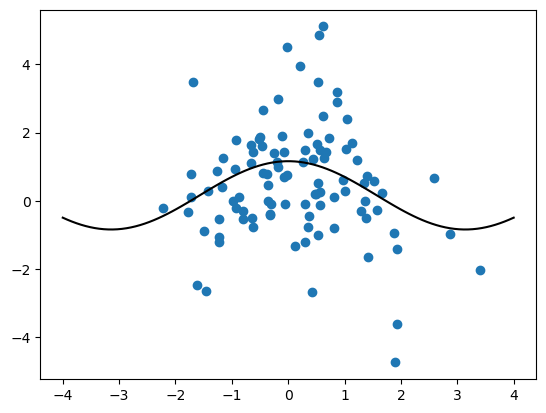

In [159]:
# Getting observational and interventional data
n = 100
n_int = 100
int_samples = 10**4
noise = 1.0
seed = 1
front_door = False
int_scale = 4

if front_door:
    method = "ATT_frontdoor_doB_b"
else:
    method = "CATE_backdoor_doD_bfixed"
    
A,B,C,D,E,Y,vals,EY = Simulation(n,n_int, 
           mc_samples_EYdoX = int_samples, 
           seed = seed, 
           draw_EYdoX = True, 
           noise = noise,
           method = method, 
           int_min=-int_scale*noise, 
           int_max = int_scale*noise,
           discrete_D = False,
           fix_b = True
            )

plt.plot(vals,EY, color = "black")
if front_door:
    plt.scatter(B,Y)
else:
    plt.scatter(D,Y)

In [160]:
# Define l, a, y as numpy arrays
l = C.numpy()
a = D[:,0].numpy()
y = Y[:,0].numpy()

# Ensure l, a, y are numpy arrays
l = np.asarray(l)
a = np.asarray(a)
y = np.asarray(y)

n, p = l.shape
a_min = -4
a_max = 4
a_vals = np.linspace(a_min, a_max, num=n_int)
num_a_vals = len(a_vals)

# Set up evaluation points & matrices for predictions
# Create la_new by stacking the original data and new data for predictions
l_repeated = np.repeat(l, num_a_vals, axis=0)
a_repeated = np.tile(a_vals, n)
la_new_extra = np.hstack([l_repeated, a_repeated.reshape(-1, 1)])
la_new = np.vstack([np.hstack([l, a.reshape(-1, 1)]), la_new_extra])
l_new = la_new[:, :-1]

# Fit Super Learner (other methods could be used here instead)
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor()),
    ('rf', RandomForestRegressor(n_estimators=100)),
    ('gb', GradientBoostingRegressor(n_estimators=100)),
    ('ridge', Ridge()),
    ('lasso', Lasso())
]

# pimod: model for a given l
pimod = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())
pimod.fit(l, a)
pimod_vals = pimod.predict(l_new)
sq_res = (a - pimod.predict(l)) ** 2

# pi2mod: model for squared residuals
pi2mod = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())
pi2mod.fit(l, sq_res)
pi2mod_vals = np.abs(pi2mod.predict(l_new))

# mumod: model for y given l and a using Random Forest Regressor
l_a = np.hstack([l, a.reshape(-1, 1)])
# Use Random Forest Regressor for muhat
mumod = RandomForestRegressor(n_estimators=100)
mumod.fit(l_a, y)
# Predict muhat_vals for both original and new data
la_new = np.vstack([np.hstack([l, a.reshape(-1, 1)]), la_new_extra])
muhat_vals = mumod.predict(la_new)

# Construct estimated pi/varpi and mu/m values
a_std = (la_new[:, -1] - pimod_vals) / np.sqrt(pi2mod_vals)
a_std_n = a_std[:n]

# Nadaraya-Watson estimation for pihat
def nadaraya_watson_density(z_vals, x_vals, h):
    n = len(x_vals)
    K = norm.pdf((z_vals[:, np.newaxis] - x_vals[np.newaxis, :]) / h)
    densities = np.sum(K, axis=1) / (n * h)
    return densities

def cross_validate_bandwidth(x_vals, K=5):
    # Define a range of bandwidths to test
    bandwidths = np.linspace(0.1 * np.std(x_vals), 2.0 * np.std(x_vals), 30)
    kf = KFold(n_splits=K, shuffle=True, random_state=1)
    best_bandwidth = None
    best_score = np.inf

    for h in bandwidths:
        cv_score = 0.0
        for train_index, test_index in kf.split(x_vals):
            x_train, x_test = x_vals[train_index], x_vals[test_index]
            # Estimate density on training data
            n_train = len(x_train)
            K_train = norm.pdf((x_test[:, np.newaxis] - x_train[np.newaxis, :]) / h)
            densities = np.sum(K_train, axis=1) / (n_train * h)
            # Compute negative log-likelihood
            log_likelihood = -np.sum(np.log(densities + 1e-10))  # Add small value to avoid log(0)
            cv_score += log_likelihood
        # Average over folds
        cv_score /= K
        if cv_score < best_score:
            best_score = cv_score
            best_bandwidth = h
    return best_bandwidth
    
h_pihat = cross_validate_bandwidth(a_std_n, K=5)
pihat_vals = nadaraya_watson_density(a_std, a_std_n, h_pihat)
pihat = pihat_vals[:n]
pihat_mat = pihat_vals[n:].reshape(n, num_a_vals)

# varpihat estimation using local linear regression
varpihat_mean = np.mean(pihat_mat, axis=0)
kr_varpihat = KernelReg(endog=varpihat_mean, exog=a_vals, var_type='c', reg_type='ll')
varpihat, _ = kr_varpihat.fit(a)
varpihat_mat = np.tile(varpihat_mean, (n, 1))

# muhat and mhat estimation using local linear regression
muhat = muhat_vals[:n]
muhat_mat = muhat_vals[n:].reshape(n, num_a_vals)
mhat_mean = np.mean(muhat_mat, axis=0)
kr_mhat = KernelReg(endog=mhat_mean, exog=a_vals, var_type='c', reg_type='ll')
mhat, _ = kr_mhat.fit(a)
mhat_mat = np.tile(mhat_mean, (n, 1))

# Form adjusted/pseudo outcome xi
pseudo_out = (y - muhat) / (pihat / varpihat) + mhat

# Leave-one-out cross-validation to select bandwidth
def kern(x):
    return norm.pdf(x)

def w_fn(bw):
    w_avals = []
    for a_val in a_vals:
        a_std = (a - a_val) / bw
        kern_std = kern(a_std) / bw
        numerator = np.mean(a_std ** 2 * kern_std) * (kern(0) / bw)
        denominator = np.mean(kern_std) * np.mean(a_std ** 2 * kern_std) - (np.mean(a_std * kern_std)) ** 2
        w_val = numerator / denominator
        w_avals.append(w_val)
    return np.array(w_avals) / n

def hatvals(bw):
    w_avals = w_fn(bw)
    hat_vals = np.interp(a, a_vals, w_avals)
    return hat_vals

def cts_eff(out, bw):
    kr = KernelReg(endog=out, exog=a, var_type='c', reg_type='ll', bw=[bw])
    y_pred, _ = kr.fit(a)
    return y_pred

def cross_val_func(h):
    hats = hatvals(h)
    y_pred = cts_eff(pseudo_out, h)
    residuals = (pseudo_out - y_pred) / (1 - hats)
    return np.mean(residuals ** 2)

res = minimize_scalar(cross_val_func, bounds=(0.01, 50), method='bounded', options={'xatol': 0.01})
h_opt = res.x

# Estimate effect curve with optimal bandwidth
kr_est = KernelReg(endog=pseudo_out, exog=a, var_type='c', reg_type='ll', bw=[h_opt])
est, _ = kr_est.fit(a_vals)

# Estimate sandwich-style pointwise confidence band
se_list = []
for idx, a_val in enumerate(a_vals):
    a_std = (a - a_val) / h_opt
    kern_std = kern(a_std) / h_opt**2  # kern_std = (kern(a_std)/h_opt)/h_opt

    # Weighted linear regression of pseudo_out ~ a_std
    X = np.vstack([np.ones_like(a_std), a_std]).T
    weights = kern_std

    # Check for small weights and filter if necessary
    threshold = 1e-10
    valid_indices = weights > threshold

    if not np.all(valid_indices):
        # Exclude observations with very small weights
        X_filtered = X[valid_indices]
        pseudo_out_filtered = pseudo_out[valid_indices]
        weights_filtered = weights[valid_indices]
        a_std_filtered = a_std[valid_indices]
    else:
        X_filtered = X
        pseudo_out_filtered = pseudo_out
        weights_filtered = weights
        a_std_filtered = a_std

    X_filtered = X
    pseudo_out_filtered = pseudo_out
    weights_filtered = weights
    a_std_filtered = a_std

    # Fit the weighted least squares model using statsmodels
    model = sm.WLS(pseudo_out_filtered, X_filtered, weights=weights_filtered)
    results = model.fit()
    beta = results.params

    # Compute Dh
    mean_kern_std = np.mean(weights_filtered)
    mean_kern_std_a_std = np.mean(weights_filtered * a_std_filtered)
    mean_kern_std_a_std2 = np.mean(weights_filtered * a_std_filtered ** 2)
    Dh = np.array([[mean_kern_std, mean_kern_std_a_std],
                   [mean_kern_std_a_std, mean_kern_std_a_std2]])

    # Compute kern_mat and g2
    a_vals_diff = (a_vals - a_val) / h_opt
    kern_mat = kern(a_vals_diff) / h_opt
    kern_mat = np.tile(kern_mat, (n, 1))
    g2 = np.tile(a_vals_diff, (n, 1))

    # Compute intfn1_mat and intfn2_mat
    intfn1_mat = kern_mat * (muhat_mat - mhat_mat) * varpihat_mat
    intfn2_mat = g2 * kern_mat * (muhat_mat - mhat_mat) * varpihat_mat

    # Compute integrals int1 and int2 for each observation
    # Using the trapezoidal rule
    delta_a_vals = np.diff(a_vals)
    delta_a_vals = np.tile(delta_a_vals, (n, 1))
    int1 = np.sum(((intfn1_mat[:, :-1] + intfn1_mat[:, 1:]) / 2) * delta_a_vals, axis=1)
    int2 = np.sum(((intfn2_mat[:, :-1] + intfn2_mat[:, 1:]) / 2) * delta_a_vals, axis=1)

    # Compute residuals
    residuals = pseudo_out - X @ beta

    # Prepare matrix for covariance calculation
    temp_matrix = np.vstack([
        weights * residuals + int1,
        a_std * weights * residuals + int2
    ])

    # Solve Dh inverse
    Dh_inv = np.linalg.inv(Dh)

    # Multiply Dh_inv by temp_matrix
    matrix = Dh_inv @ temp_matrix

    # Compute covariance matrix sigma
    sigma = np.cov(matrix)

    # Append standard error
    se_list.append(np.sqrt(sigma[0, 0]))

# Convert se_list to array
se_array = np.array(se_list)
mu = torch.tensor(est).view(len(est),1)
var = torch.tensor(se_array**2/n).view(len(se_array),1)

/tmp/ipykernel_421064/2719777230.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  w_val = numerator / denominator


(-2.5, 4.5)

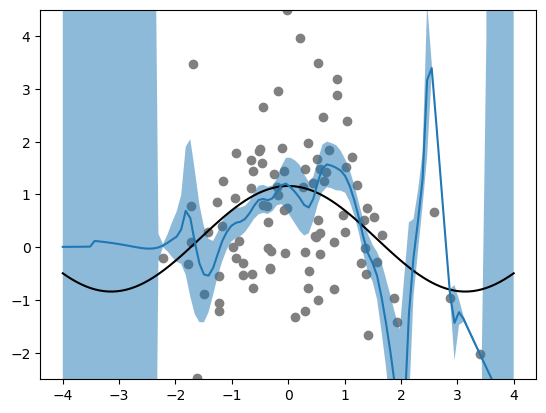

In [161]:
plt.scatter(a,y, color = "grey")
plt.plot(vals,EY, color = "black")
plt.plot(vals,mu)
plt.fill_between(a_vals,(mu-2*var**0.5)[:,0],(mu+2*var**0.5)[:,0], alpha = 0.5)
plt.ylim(-2.5,4.5)